In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
import sys
import glob
import csv 
import itertools
import Levenshtein
import statistics
import torch
import scipy.stats

aminoacids = 'CMFILVWYAGTSNQDEHRKP-'
AAbasis = list(aminoacids)
aminoacids_set = set(AAbasis)
_aatonumber = {c: i for i, c in enumerate(aminoacids)}
_numbertoaa = {i: c for i, c in enumerate(aminoacids)}

In [2]:
############################################################

In [3]:
def DF_list(data):
    s1 = list(data['Seq1'])
    s2 = list(data['Seq2'])
    f1 = [sum([1 for y in x if y == '*']) > 0 for x in s1]
    f2 = [sum([1 for y in x if y == '*']) > 0 for x in s2]
    
    out = list(zip(s1,s2))
    out = [x for i, x in enumerate(out) if f1[i] == 0 and f2[i] == 0]
    for i, (x,y) in enumerate(out):
        if len(y) > len(x): # longer one first
            out[i] = (y,x)
    return out
def nmat_gen(pairs,dmax): # L1 pos1 i1_1 i2_1 L1 pos1 i1_1 i2_1 ...  
    matrix1 = -1*np.ones((len(pairs),4*dmax),dtype = int)
    for ind1, (s1, s2) in enumerate(pairs):
        steps = Levenshtein.editops(s1,s2)
        LOP = max([len(s1),len(s2)])
        for ind, (op, i1, i2) in enumerate(steps):
            if op == 'replace': # 1 is replace
                ii1, ii2 = sorted([_aatonumber[s1[i1]],_aatonumber[s2[i2]]])
                matrix1[ind1,(4*ind):(4*(ind+1))] = [LOP, i1, ii1, ii2]
            if op == 'delete': # 0 is delete or insert
                ii1, ii2 = sorted([_aatonumber[s1[i1]],20]) # 20 is blank
                matrix1[ind1,(4*ind):(4*(ind+1))] = [LOP, i1, ii1, ii2]
            if op == 'insert': # 0 is delete or insert
                ii1, ii2 = sorted([_aatonumber[s2[i2]],20]) # 20 is blank
                matrix1[ind1,(4*ind):(4*(ind+1))] = [LOP, i1, ii1, ii2]
    matrix = []
    matrix.extend(matrix1)
    return np.array(matrix)

In [4]:
############################################################

In [5]:
def optimize(LVR=3, niter=1000, lr=1e-2, disp=True):
    max_length = 30
    
    # preallocate
    aa_distance = torch.zeros((len(aminoacids), len(aminoacids)), requires_grad=True)
    pos_weights = torch.zeros((max_length, max_length), requires_grad=True)

    # optimize
    optimizer = torch.optim.Adam([aa_distance, pos_weights], lr=lr)
    loss_out = np.zeros(niter)
    
    for i in range(niter):
        optimizer.zero_grad()
        loss = loss_nll(MATs,aa_distance, pos_weights)
        loss_out[i] = loss
        loss.backward()
        optimizer.step()
        rq = ('step ' + str(i+1) + ' out of ' + str(niter) + ' complete!')
        sys.stdout.write('\r'+rq)
    return loss_out, aa_distance, pos_weights
def optimize_AA(LVR=3, niter=1000, lr=1e-2, disp=True):
    max_length = 30
    
    # preallocate
    aa_distance = torch.zeros((len(aminoacids), len(aminoacids)), requires_grad=True)
    pos_weights = torch.zeros((max_length, max_length), requires_grad=True)

    # optimize
    optimizer = torch.optim.Adam([aa_distance, pos_weights], lr=lr)
    loss_out = np.zeros(niter)
    
    for i in range(niter):
        optimizer.zero_grad()
        loss = loss_nll_AA(MATs,aa_distance, pos_weights)
        loss_out[i] = loss
        loss.backward()
        optimizer.step()
        rq = ('step ' + str(i+1) + ' out of ' + str(niter) + ' complete!')
        sys.stdout.write('\r'+rq)
    return loss_out, aa_distance, pos_weights
def optimize_pos(LVR=3, niter=1000, lr=1e-2, disp=True):
    max_length = 30
    
    # preallocate
    aa_distance = torch.zeros((len(aminoacids), len(aminoacids)), requires_grad=True)
    pos_weights = torch.zeros((max_length, max_length), requires_grad=True)

    # optimize
    optimizer = torch.optim.Adam([aa_distance, pos_weights], lr=lr)
    loss_out = np.zeros(niter)
    
    for i in range(niter):
        optimizer.zero_grad()
        loss = loss_nll_pos(MATs,aa_distance, pos_weights)
        loss_out[i] = loss
        loss.backward()
        optimizer.step()
        rq = ('step ' + str(i+1) + ' out of ' + str(niter) + ' complete!')
        sys.stdout.write('\r'+rq)
    return loss_out, aa_distance, pos_weights
def loss_nll(MATs, aa_distance, pos_weights):
    R = 0
    for r in range(len(MATs)):
        dp = distance(MATs[r][0], aa_distance, pos_weights)
        dn = distance(MATs[r][1], aa_distance, pos_weights)
        R += (dp).mean() + torch.logsumexp(-dn, 0) 
    return R
def loss_nll_AA(MATs, aa_distance, pos_weights):
    R = 0
    for r in range(len(MATs)):
        dp = distance_AA(MATs[r][0], aa_distance, pos_weights)
        dn = distance_AA(MATs[r][1], aa_distance, pos_weights)
        R += (dp).mean() + torch.logsumexp(-dn, 0) 
    return R
def loss_nll_pos(MATs, aa_distance, pos_weights):
    R = 0
    for r in range(len(MATs)):
        dp = distance_pos(MATs[r][0], aa_distance, pos_weights)
        dn = distance_pos(MATs[r][1], aa_distance, pos_weights)
        R += (dp).mean() + torch.logsumexp(-dn, 0) 
    return R
def distance(matrix, aa_distance, pos_weights):
    L = matrix[:,0::4]
    pos = matrix[:,1::4]
    i1 = matrix[:,2::4]
    i2 = matrix[:,3::4]
    PW = 5*(torch.sigmoid(pos_weights))
    AW = 5*(torch.sigmoid(aa_distance))
    
    for ii in range(d):
        if ii == 0:
            a = (PW[L[:,ii],pos[:,ii]])
            b = (AW[i1[:,ii], i2[:,ii]])
            ab = -torch.log(1 - (1-torch.exp(-a))*(1-torch.exp(-b)))
        if ii != 0:
            a = (PW[L[:,ii],pos[:,ii]])
            b = (AW[i1[:,ii], i2[:,ii]])
            ab = ab - torch.log(1 - (1-torch.exp(-a))*(1-torch.exp(-b)))
    return ab
def distance_pos(matrix, aa_distance, pos_weights):
    L = matrix[:,0::4]
    pos = matrix[:,1::4]
    i1 = matrix[:,2::4]
    i2 = matrix[:,3::4]
    PW = 5*(torch.sigmoid(pos_weights))
    AW = 5*(torch.sigmoid(aa_distance))
    
    for ii in range(d):
        if ii == 0:
            a = (PW[L[:,ii],pos[:,ii]])
            ab = a
        if ii != 0:
            ab = ab + (PW[L[:,ii],pos[:,ii]])
    return ab
def distance_AA(matrix, aa_distance, pos_weights):
    L = matrix[:,0::4]
    pos = matrix[:,1::4]
    i1 = matrix[:,2::4]
    i2 = matrix[:,3::4]
    PW = 5*(torch.sigmoid(pos_weights))
    AW = 5*(torch.sigmoid(aa_distance))
    
    for ii in range(d):
        if ii == 0:
            b = (AW[i1[:,ii], i2[:,ii]])
            ab = b
        if ii != 0:
            ab = ab + (AW[i1[:,ii], i2[:,ii]])
    return ab
def Awei(Mat):
    y = []
    for i in range(d):
        for x in Mat:
            y.append([x[2 + i*4], x[3 + i*4]])
    out = np.zeros((21,21));
    for r in y:
        out[r[0],r[1]] += 1
    return out
def Lwei(Mat):
    y = []
    for i in range(d):
        for x in Mat:
            y.append([x[i*4], x[1 + i*4]])
    out = np.zeros((30,30));
    for r in y:
        out[r[0],r[1]] += 1
    return out
def mat_out(aa_w,pos_w):
    PW = 5*(torch.sigmoid(pos_w))
    PW = PW.detach().numpy().copy()
    AW = 5*(torch.sigmoid(aa_w) ) 
    AW = AW.detach().numpy().copy()
    for i in range(21):
        for j in range(i,21):
            AW[j,i] = AW[i,j]
            if i == j:
                AW[i,i] = np.nan
    return AW, PW
def qSUBwei2(Mat):
    out = np.zeros([21,21])
    for x in Mat:
        out[x[2],x[3]] += 1
    return out

In [6]:
############################################################

In [7]:
d = 1
MMR = 1000
filepath = 'seqs/'
Rep = 15

MATs = []
rho_AA = np.zeros([21,21])
rho_pos = np.zeros([30,30])
for r in range(Rep):
    s_pairs = DF_list(pd.read_csv(filepath + 'Pairs_MIRA_train_'+ str(MMR) + '_LD_'+str(d)+'_'+str(r)+'.csv'))
    c_pairs = DF_list(pd.read_csv(filepath + 'Bkg_MIRA_Pairs_train_'+ str(MMR) + '_LD_'+str(d)+'_'+str(r)+'.csv'))
    Mat_t = nmat_gen(s_pairs,d)
    Mat_bkgn_t = list(nmat_gen(c_pairs,d))
    Mat_bkgn_t.extend(list(Mat_t))
    Mat_bkgn_t = np.array(Mat_bkgn_t)
    MATs.append([Mat_t,Mat_bkgn_t])
    rho_AA += qSUBwei2(Mat_bkgn_t)
    rho_pos += Lwei(Mat_bkgn_t)

rho_AA += np.transpose(rho_AA)

d_AP:
step 12000 out of 12000 complete!
d_A:
step 5000 out of 5000 complete!
d_P:
step 3000 out of 3000 complete!

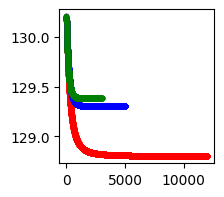

In [8]:
plt.figure(figsize=(2,2))

print('d_AP:')
kwargs = dict(LVR=d, niter = 12000, lr = 1e-3)
loss_out, aa_distance_AP, pos_weights_AP = optimize(**kwargs)
plt.plot(loss_out,'r.')
AW_d, PW_d = mat_out(aa_distance_AP,pos_weights_AP)

print('\nd_A:')
kwargs = dict(LVR=d, niter = 5000, lr = 1e-3)
loss_out, aa_distance, pos_weights = optimize_AA(**kwargs)
plt.plot(loss_out,'b.')
AW, _ = mat_out(aa_distance,pos_weights)

print('\nd_P:')
kwargs = dict(LVR=d, niter = 3000, lr = 1e-3)
loss_out, aa_distance, pos_weights = optimize_pos(**kwargs)
plt.plot(loss_out,'g.')
_, PW = mat_out(aa_distance,pos_weights)

# df

In [9]:
Rep = 15
d = 1
d_all = []
for r in range(Rep):
    s_pairs = DF_list(pd.read_csv(filepath + 'Pairs_MIRA_train_'+ str(MMR) + '_LD_'+str(d)+'_'+str(r)+'.csv'))
    c_pairs = DF_list(pd.read_csv(filepath + 'Bkg_MIRA_Pairs_train_'+ str(MMR) + '_LD_'+str(d)+'_'+str(r)+'.csv'))
    Mat = nmat_gen(s_pairs,d)
    Mat_bkgn = list(nmat_gen(c_pairs,d))
    Mat_bkgn.extend(list(Mat))
    Mat_bkgn = np.array(Mat_bkgn)
    d_all.append(list(distance(Mat_bkgn, aa_distance_AP, pos_weights_AP)))
d_all2 = []

for y in d_all:
    temp = []
    for x in y:
        temp.append(x.detach().numpy())
    d_all2.append(temp)
d_all = d_all2
Log_exp_d_av = [np.log(np.mean(np.exp(-np.array(x)))) for x in d_all]
LED_av_AP = np.mean(Log_exp_d_av)

In [10]:
##########################

In [11]:
########################## print figures ##########################

In [12]:
SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [13]:
print('average contact probability: ' +  str(np.nansum((1-np.exp(-PW_d))*rho_pos)/np.nansum(rho_pos)))
print('average probability of maintaining co-specificity: ' + str(np.exp(-np.nansum(AW_d*rho_AA)/np.nansum(rho_AA))))

average contact probability: 0.8785133196135836
average probability of maintaining co-specificity: 0.11941132849563481


In [14]:
PW_d_av = np.nansum(PW_d*rho_pos)/np.nansum(rho_pos)
AW_d_av = np.nansum(AW_d*rho_AA)/np.nansum(rho_AA)
AW_d_av_AAs = np.nansum(AW_d[:20,:20]*rho_AA[:20,:20])/np.nansum(rho_AA[:20,:20])
AW_d_av_indels = np.nansum(AW_d[:20,20]*rho_AA[:20,20])/np.nansum(rho_AA[:20,20])

<Axes: >

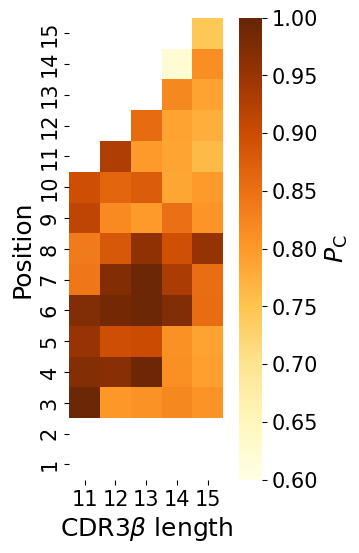

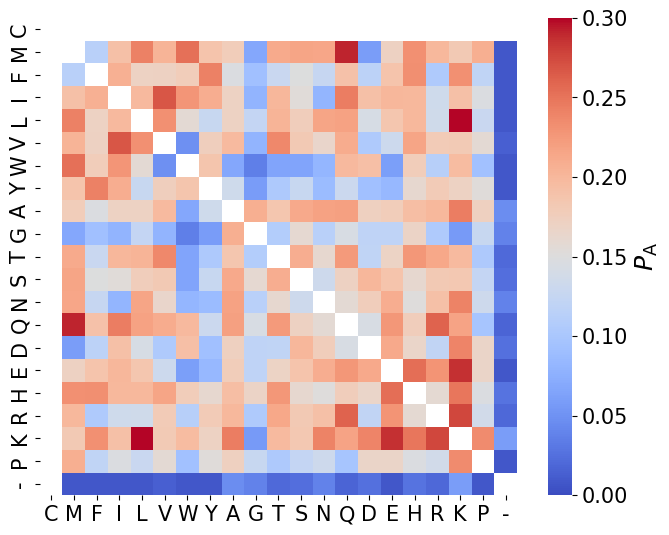

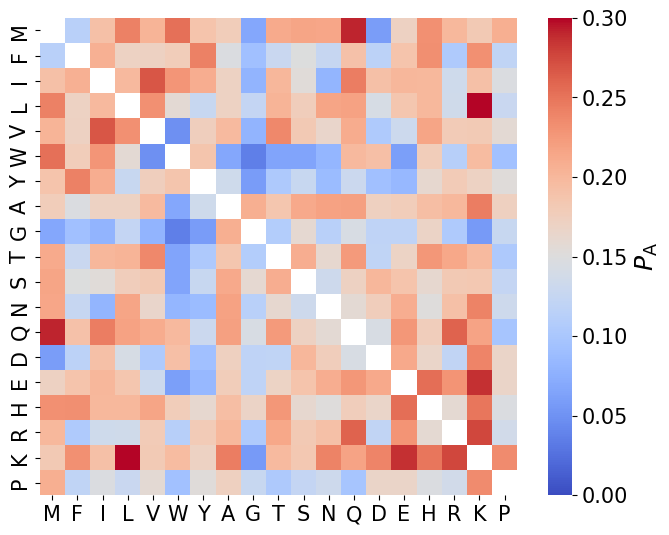

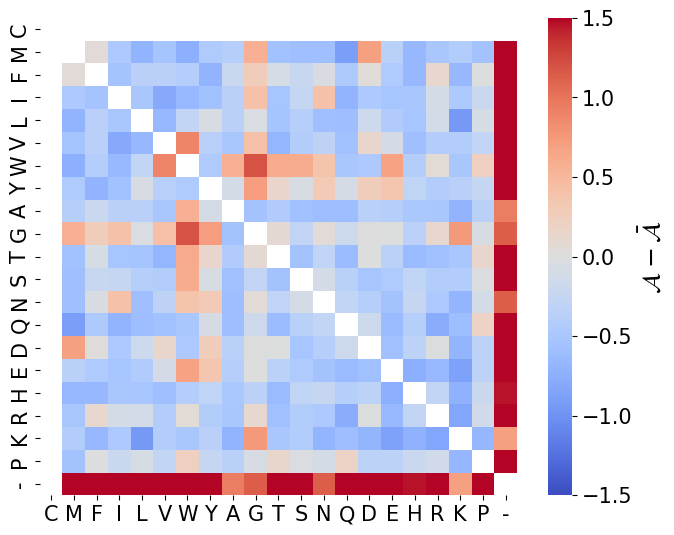

In [15]:
i1 = 11
i2 = 15

QW = PW_d[i1:(i2+1),:i2].copy() #- PW_d_av
QW_rho = rho_pos[i1:(i2+1),:i2].copy()
QW[QW == 2.5] = np.nan
QW[QW_rho < 1] = np.nan
y = 1 - np.exp(-np.transpose(QW))

# for i in range(5):
#     y[:,i] = y[:,i]/np.nansum(y[:,i])


plt.figure(figsize=(4,6))
df = pd.DataFrame(data=y,index = list(range(1,i2+1)),columns = list(range(i1,i2+1)))
ax = sns.heatmap(df, square='true',cmap = "YlOrBr", vmin=0.6,vmax = 1,cbar_kws={'label': r'$P_\mathrm{C}$'})
ax.invert_yaxis()
plt.xlabel(r'CDR3$\beta$ length')
plt.ylabel('Position')


QAW = AW_d.copy() #- AW_d_av
QAW[QAW == 2.5] = np.nan
QAW[rho_AA < 5] = np.nan

z = np.exp(-QAW)
z[0,:] = np.nan
z[:,0] = np.nan

prob_AS_dual = z.copy()

plt.figure(figsize=(8,6.2))
df = pd.DataFrame(data=z,columns=AAbasis[:21],index=AAbasis[:21])
sns.heatmap(df, square='true', cmap='coolwarm',vmin = 0, vmax = 0.3,cbar_kws={'label': r'$P_\mathrm{A}$'})


QAW = AW_d.copy() #- AW_d_av
QAW[QAW == 2.5] = np.nan
QAW[rho_AA < 1] = np.nan

plt.figure(figsize=(8,6.2))
df = pd.DataFrame(data=np.exp(-QAW[1:20,1:20]),columns=AAbasis[1:20],index=AAbasis[1:20])
sns.heatmap(df, square='true', cmap='coolwarm',vmin = 0, vmax = 0.3,cbar_kws={'label': r'$P_\mathrm{A}$'})

QAW = AW_d.copy() - np.nansum(AW_d.copy()*rho_AA)/np.nansum(rho_AA)
# QAW[QAW == 2.5] = np.nan
QAW[rho_AA < 1] = np.nan
QAW[0,:] = np.nan; QAW[:,0] = np.nan
plt.figure(figsize=(8,6.2))
df = pd.DataFrame(data=QAW[0:21,0:21],columns=AAbasis[0:21],index=AAbasis[0:21])
sns.heatmap(df, square='true', cmap='coolwarm',vmin = -1.5, vmax = 1.5,cbar_kws={'label': r'$\mathcal{A}-\bar{\mathcal{A}}$'})


<Axes: >

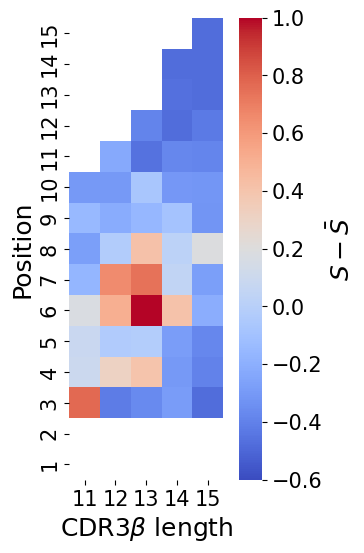

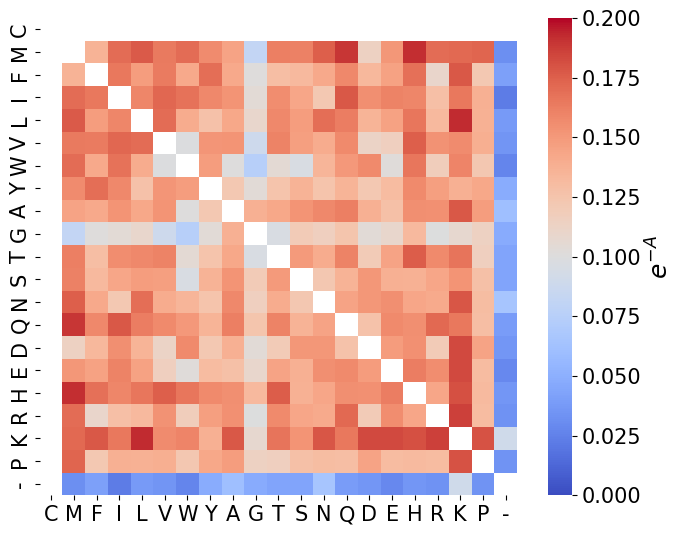

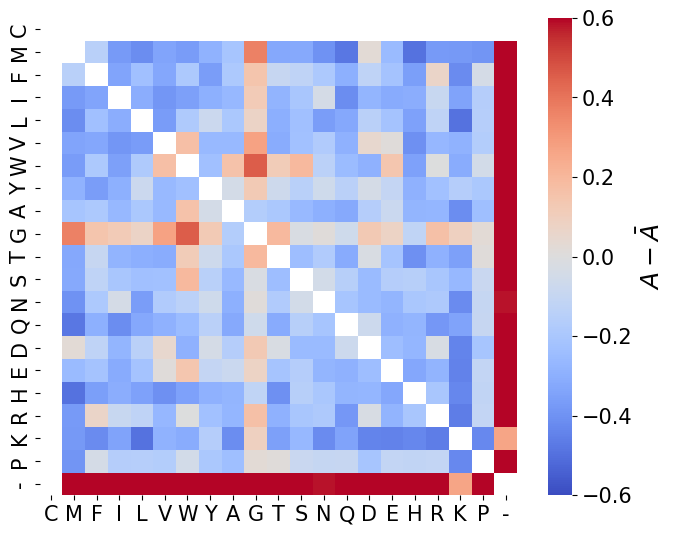

In [16]:
QW = PW[i1:(i2+1),:i2].copy()
QW_rho = rho_pos[i1:(i2+1),:i2].copy()
QW[QW == 2.5] = np.nan
QW[QW_rho < 1] = np.nan

ART = np.nansum(QW*QW_rho)/np.nansum(QW_rho)


plt.figure(figsize=(4,6))
df = pd.DataFrame(data=np.transpose(QW) - ART,index = list(range(1,i2+1)),columns = list(range(i1,i2+1)))
ax = sns.heatmap(df, square='true', cmap='coolwarm',cbar_kws={'label': r'$S-\bar{S}$'}, vmin = -0.6,vmax = 1)
ax.invert_yaxis()
plt.xlabel(r'CDR3$\beta$ length')
plt.ylabel('Position')

QAW = AW.copy()
QAW[QAW == 2.5] = np.nan
QAW[rho_AA < 1] = np.nan

ART = np.nansum(QAW*rho_AA)/np.nansum(rho_AA)

z = np.exp(-QAW)
z[0,:] = np.nan
z[:,0] = np.nan

prob_Aonly = z.copy()

plt.figure(figsize=(8,6.2))
df = pd.DataFrame(data=z,columns=AAbasis[0:21],index=AAbasis[0:21])
sns.heatmap(df, square='true', cmap='coolwarm', vmin = 0,vmax = 0.2,cbar_kws={'label': r'$e^{-A}$'})

QAW = AW.copy()
QAW[QAW == 2.5] = np.nan
QAW[rho_AA < 1] = np.nan
QAW[0,:] = np.nan
QAW[:,0] = np.nan

ART = np.nansum(QAW*rho_AA)/np.nansum(rho_AA)

plt.figure(figsize=(8,6.2))
df = pd.DataFrame(data=QAW[0:21,0:21] - ART,columns=AAbasis[0:21],index=AAbasis[0:21])
sns.heatmap(df, square='true', cmap='coolwarm', vmin = -0.6,vmax = 0.6,cbar_kws={'label': r'$A-\bar{A}$'})

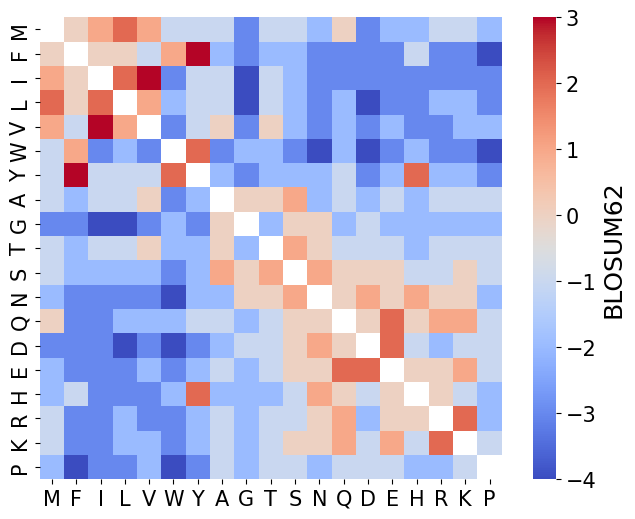

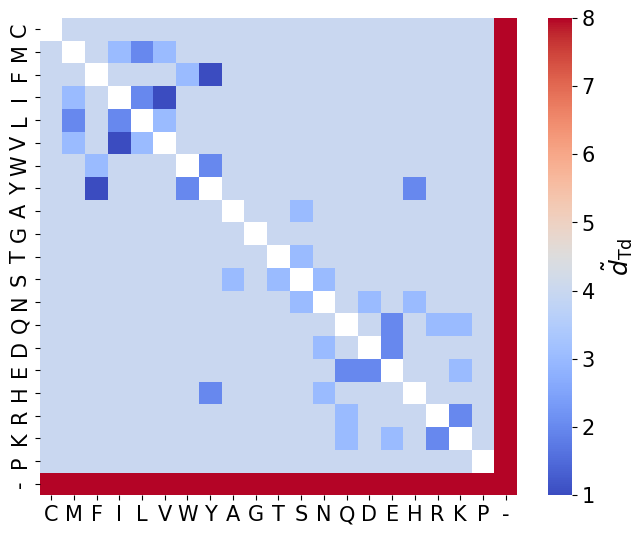

In [17]:
data = pd.read_csv('data/blosum.csv')
data = np.array(data)
Bmat = np.zeros([20,20])
inder = []
for i in range(20):
    Bmat[i,:] = data[i,1:21]
    inder.append(data[i,0])
Bmat_ordered = np.zeros([20,20])
for i in range(20):
    ii = [kk for kk,t in enumerate(list(aminoacids)) if t == inder[i]][0]
    for j in range(20):
        jj = [kk for kk,t in enumerate(list(aminoacids)) if t == inder[j]][0]
        Bmat_ordered[ii,jj] = Bmat[i,j]
np.fill_diagonal(Bmat_ordered, np.nan)
plt.figure(figsize=(8,6))

df = pd.DataFrame(data = Bmat_ordered[1:,1:], index=list(aminoacids)[1:20], columns=list(aminoacids)[1:20])
sns.heatmap(df, square='true', cmap='coolwarm',vmin= -4,vmax = 3,cbar_kws={'label': 'BLOSUM62'})
BLO = -Bmat_ordered.copy()
BLO_ref = Bmat_ordered.copy()

Bmat_TCRhist = np.zeros([21,21])
Bmat_TCRhist[:20,:20] = BLO_ref
for i in range(21):
    for j in range(21):
        if i < 20 and j < 20:
            Bmat_TCRhist[i,j] = np.min([4 - Bmat_TCRhist[i,j], 4])
        if i == 20 or j == 20:
            Bmat_TCRhist[i,j] = 8
plt.figure(figsize=(8,6.2))
# plt.title('BLOSUM62')
df = pd.DataFrame(data =Bmat_TCRhist, index=list(aminoacids)[:21], columns=list(aminoacids)[:21])
sns.heatmap(df, square='true', cmap='coolwarm',cbar_kws={'label': r'$\tilde{d}_\mathrm{Td}$'})#,vmin= -4,vmax = 4)
BLO = -Bmat_ordered.copy()
BLO_ref = Bmat_ordered.copy()

In [18]:
########################## correlations ####b######################

([<matplotlib.axis.XTick at 0x12fd8fed0>,
 [Text(0, 0, '0'), Text(2, 0, '2'), Text(4, 0, '4'), Text(6, 0, '6')])

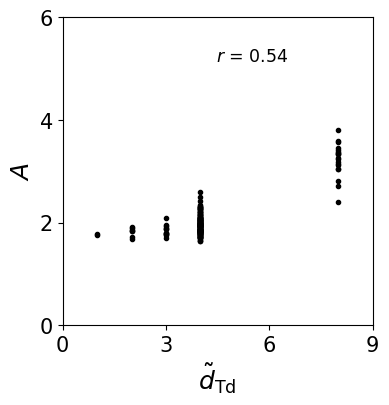

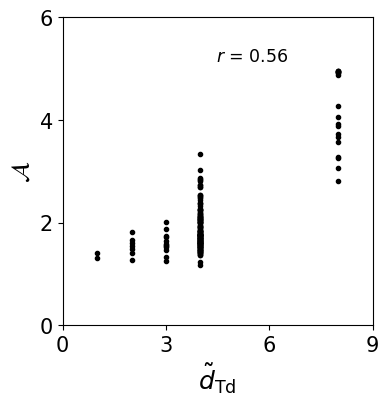

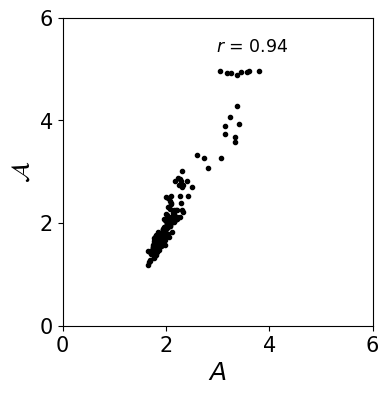

In [19]:
# prob_Aonly, prob_AS_dual, Bmat_TCRhist
def corrl_runner(Mz1, Mz2):
    y1 = []
    y2 = []
    for i in range(1,20):
        for j in range(i+1, 21):
            if Mz1[i,j] == Mz1[i,j] and Mz2[i,j] == Mz2[i,j]:
                if rho_AA[i,j]/Rep >= 1:
                    y1.extend([Mz1[i,j]])
                    y2.extend([Mz2[i,j]])
    y1 = (np.array(y1))
    return y1, y2

y1, y2 = corrl_runner(-np.log(prob_Aonly), Bmat_TCRhist)

plt.figure(figsize = (4,4))
plt.ylabel(r'$A$')
plt.xlabel(r'$\tilde{d}_\mathrm{Td}$')
plt.plot(y2, y1,'k.')
spearman = scipy.stats.spearmanr(y2, y1)
plt.text(0.7, 0.63, f'$r$ = {round(spearman.correlation, 2)}', transform=ax.transAxes,
         ha='center', va='top', fontsize='small')

plt.ylim([0,6])
plt.yticks([0,2,4,6])
plt.xlim([0,9])
plt.xticks([0,3,6,9])

y1, y2 = corrl_runner(-np.log(prob_AS_dual), Bmat_TCRhist)

plt.figure(figsize = (4,4))
plt.ylabel(r'$\mathcal{A}$')
plt.xlabel(r'$\tilde{d}_\mathrm{Td}$')
plt.plot(y2, y1,'k.')
spearman = scipy.stats.spearmanr(y2, y1)
plt.text(0.7, 0.63, f'$r$ = {round(spearman.correlation, 2)}', transform=ax.transAxes,
         ha='center', va='top', fontsize='small')
plt.ylim([0,6])
plt.yticks([0,2,4,6])
plt.xlim([0,9])
plt.xticks([0,3,6,9])

y1, y2 = corrl_runner(-np.log(prob_AS_dual),-np.log(prob_Aonly))

plt.figure(figsize = (4,4))
plt.xlabel(r'$A$')
plt.ylabel(r'$\mathcal{A}$')
plt.plot(y2, y1,'k.')
spearman = scipy.stats.spearmanr(y2, y1)
plt.text(0.7, 0.63, f'$r$ = {round(spearman.correlation, 2)}', transform=ax.transAxes,
         ha='center', va='top', fontsize='small')
plt.ylim([0,6])
plt.yticks([0,2,4,6])
plt.xlim([0,6])
plt.xticks([0,2,4,6])

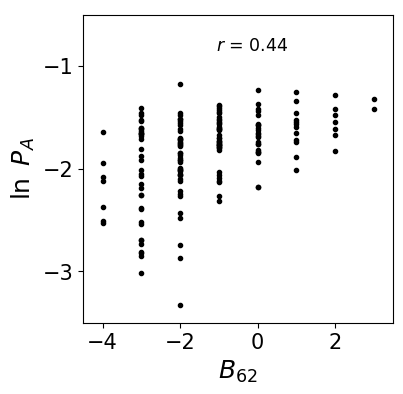

In [20]:
Mz1 = np.log(np.exp(-AW_d)) #- AW_d_av
Mz1[rho_AA < 1]= np.nan
Mz2 = BLO_ref.copy()
y1 = []
y2 = []
for i in range(1,19):
    for j in range(i+1, 20):
        if Mz1[i,j] == Mz1[i,j] and Mz2[i,j] == Mz2[i,j]:
            y1.extend([Mz1[i,j]])
            y2.extend([Mz2[i,j]])
y1 = (np.array(y1))
plt.figure(figsize = (4,4))
plt.ylabel(r'$\ln \ P_{A}$')
plt.xlabel('$B_{62}$')
plt.plot(y2, y1,'k.')
spearman = scipy.stats.spearmanr(y2, y1)
plt.text(0.7, 0.63, f'$r$ = {round(spearman.correlation, 2)}', transform=ax.transAxes,
         ha='center', va='top', fontsize='small')
plt.ylim([-3.5,-0.5]);
plt.yticks([-3,-2,-1]);
plt.xlim([-4.5,3.5]);
plt.xticks([-4,-2,0,2]);

Text(108.72222222222224, 0.5, 'Position')

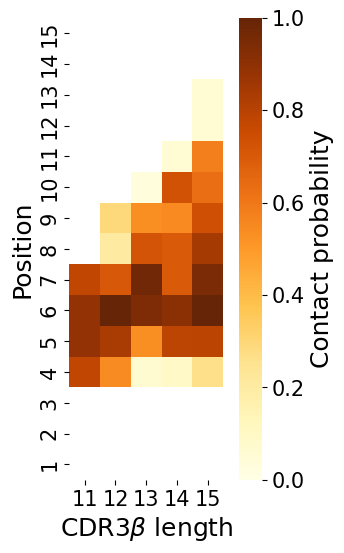

In [21]:
M = 20
df = pd.read_csv('data/contact_prob_threshold_5.csv')
A = np.transpose(df.to_numpy())
A2 = A.copy()
A3 = []
for i in range(len(A2[0,:])):
    temp = A2[:,i]
    for j,x in enumerate(temp):
        if x != x:
            temp[j] = 0
    A3.append(temp)#/np.nansum(A2[:,i]))
A3 = np.transpose(A3)
A3[A3 == 0] = np.nan


plt.figure(figsize=(4,6))
df = pd.DataFrame(data = A3[0:15,9:14],index = range(1,16), columns = range(11,16))
ax = sns.heatmap(df, square='true', cmap='YlOrBr',cbar_kws={'label': 'Contact probability'},vmin = 0, vmax = 1)
ax.invert_yaxis()
plt.xlabel(r'CDR3$\beta$ length')
plt.ylabel(r'Position')

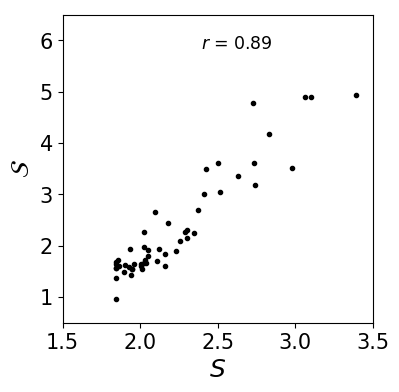

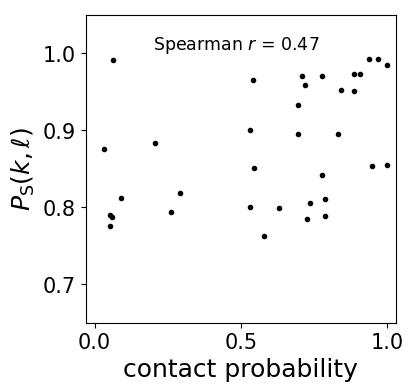

In [22]:
QW2 = PW_d[11:16,:17].copy()
QW2[rho_pos[11:16,:17] < 1] = np.nan

ART = np.nansum(QW2*rho_pos[11:16,:17])/np.nansum(rho_pos[11:16,:17])

FRR = PW[11:16,:17].copy()

x_pwei = []
x_pcont = []

for i in range(5):
    y1 = QW2[i]
    y2 = FRR[i]
    for j in range(len(y1)):
        if y1[j] == y1[j] and y2[j] == y2[j]:
            x_pwei.append(y1[j])
            x_pcont.append(y2[j])
            
x_pwei = np.array(x_pwei)
x_pcont = np.array(x_pcont)
                    
plt.figure(figsize = (4,4))
plt.plot(x_pcont, x_pwei,'k.')
plt.xlabel(r'$S$')
plt.ylabel(r'$\mathcal{S}$')
spearman = scipy.stats.spearmanr(x_pcont, x_pwei)
plt.text(0.6, 0.63, f'$r$ = {round(spearman.correlation, 2)}', transform=ax.transAxes,
         ha='center', va='top', fontsize='small')

plt.xlim([1.5,3.5]);
plt.ylim([0.5,6.5]);

QW2 = 1 - np.exp(-PW_d[11:16,:17].copy())
QW2[rho_pos[11:16,:17] < 1] = np.nan

ART = np.nansum(QW2*rho_pos[11:16,:17])/np.nansum(rho_pos[11:16,:17])

FRR = A3[0:16,9:14].copy()
FRR[FRR==0] = np.nan
FRR = np.transpose(FRR)

x_pwei = []
x_pcont = []

for i in range(5):
    y1 = QW2[i] 
    y2 = FRR[i]
    for j in range(len(y1)):
        if y1[j] == y1[j] and y2[j] == y2[j]:
            x_pwei.append(y1[j])
            x_pcont.append(y2[j])
            
x_pwei = np.array(x_pwei)
x_pcont = np.array(x_pcont)
                    
            
plt.figure(figsize = (4,4))
plt.plot(x_pcont, x_pwei,'k.')
plt.ylabel(r'$P_\mathrm{S}(k,\ell)$')
plt.xlabel('contact probability')
spearman = scipy.stats.spearmanr(x_pcont, x_pwei)
plt.text(0.6, 0.63, f'Spearman $r$ = {round(spearman.correlation, 2)}', transform=ax.transAxes,
         ha='center', va='top', fontsize='small')
plt.ylim([0.65,1.05]);
plt.yticks([0.7,0.8,0.9,1]);
plt.xlim([-0.03,1.03]);
plt.xticks([0,0.5,1]);

In [23]:
########################## property comparisons ##########################

In [24]:
def Mat_Maker(vec):
    out = np.zeros([len(vec),len(vec)])
    for i in range(len(vec)):
        for j in range(i+1,len(vec)):
            out[i,j] = np.abs(vec[i]-vec[j])
            out[j,i] = out[i,j]
    return out
def vec_matter(mat1):
    out = []
    for i in range(len(mat1)):
        for j in range(i+1,len(mat1)):
            out.append(mat1[i,j])
    return out

In [25]:
data = pd.read_csv('data/prop_table.csv')
Abb = list(data['abbr.'])
Vvals = []
for i in range(1,51):
    strN = 'V' + str(i)
    temp = list(data[strN])
    temp2 = []
    for j in range(1,20):
        for k in range(20):
            if Abb[k] == AAbasis[j]:
                z = temp[k]
                if z != '-':
                    z = float(z)
                if z == '-':
                    z = np.nan
                temp2.append(z)
    Vvals.append(temp2)
comp_mats = []
comp_vecs = []
for vec in Vvals:
    temp = Mat_Maker(vec)
    comp_mats.append(temp)
    comp_vecs.append(vec_matter(temp))

BLO_vec = vec_matter(-BLO_ref[1:20,1:20])
ML_vec = vec_matter(AW_d[1:20,1:20])
############################
r_ML = []
r_BLO = []
for z in comp_vecs:
    z_ML = [z[i] for i in range(len(z)) if z[i] == z[i] and ML_vec[i] == ML_vec[i]]
    z_BLO = [z[i] for i in range(len(z)) if z[i] == z[i] and BLO_vec[i] == BLO_vec[i]]
    ML_vec_in = [ML_vec[i] for i in range(len(z)) if z[i] == z[i] and ML_vec[i] == ML_vec[i]]
    BLO_vec_in = [BLO_vec[i] for i in range(len(z)) if z[i] == z[i] and BLO_vec[i] == BLO_vec[i]]
    r_ML.append(scipy.stats.spearmanr(z_ML, ML_vec_in).correlation)
    r_BLO.append(scipy.stats.spearmanr(z_BLO, BLO_vec_in).correlation)
r_ML = np.array(r_ML)
r_BLO_neg = np.array(r_BLO)
############################
BLO_h = r_BLO_neg[:18]
ML_h = r_ML[:18]
xh = list(range(18))
BLO_s = r_BLO_neg[18:35]
ML_s = r_ML[18:35]
xs = list(range(18,35))
BLO_e = r_BLO_neg[35:]
ML_e = r_ML[35:]
xe = list(range(35,50))

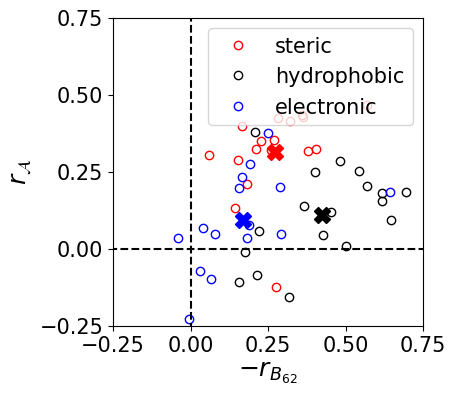

In [26]:
plt.figure(figsize=(4,4))
plt.plot(r_BLO_neg[18:35],r_ML[18:35],'ro',mfc='none') # steric
plt.plot(r_BLO_neg[:18],r_ML[:18],'ko',mfc='none') # hydrophobic
plt.plot(r_BLO_neg[35:],r_ML[35:],'bo',mfc='none') # electronic
plt.ylim([-0.25,0.75])
# plt.ylim([0,0.3])
plt.xlim([-0.25,0.75])
plt.yticks([-0.25,0,0.25,.5,.75])
plt.xticks([-0.25,0,0.25,0.5,0.75])
plt.xlabel(r'$-r_{B_{62}}$')
plt.ylabel(r'$r_{\mathcal{A}}$')

y1 = [np.mean(BLO_h),np.mean(BLO_s),np.mean(BLO_e)]
y2 = [np.mean(ML_h),np.mean(ML_s),np.mean(ML_e)]

plt.plot([0,0],[-1,1],'k--')
plt.plot([-1,1],[0,0],'k--')

plt.plot(y1[0],y2[0],'kX',markersize=12)
plt.plot(y1[1],y2[1],'rX',markersize=12)
plt.plot(y1[2],y2[2],'bX',markersize=12)
plt.legend(['steric','hydrophobic','electronic'])

Text(0.5, 0, 'properties')

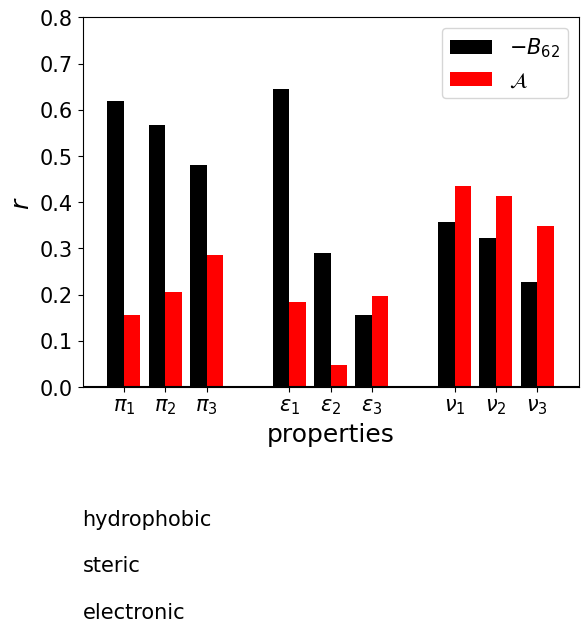

In [27]:
axh = np.flipud(np.array([xh[i] for i in np.argsort(BLO_h)]))
axs =  np.flipud(np.array([xs[i] for i in np.argsort(BLO_s)]))
axe =  np.flipud(np.array([xe[i] for i in np.argsort(BLO_e)]))

axh = np.flipud(np.array([xh[i] for i in np.argsort(ML_h)]))
axs =  np.flipud(np.array([xs[i] for i in np.argsort(ML_s)]))
axe =  np.flipud(np.array([xe[i] for i in np.argsort(ML_e)]))

M = 3
vvi = []
vvi.extend(list(axh[:M]))
vvi.extend(list(axe[:M]))
vvi.extend(list(axs[:M]))

vvi = list(np.array([17,3,14,   44,50,49,   19,22,25]) - 1)
y1 = [r_BLO_neg[x] for x in vvi]
y2 = [r_ML[x] for x in vvi]

x = []
x.extend(list(range(M)))
x.extend(list(range(M+1, 2*M+1)))
x.extend(list(range(2*M+2,3*M+2)))
x = np.array(x)

plt.bar(x-0.2,y1,width=0.4,color='k')
plt.bar(x+0.2,y2,width=0.4,color='r')
plt.legend([r'$-B_{62}$',r'$\mathcal{A}$'])
plt.plot([-2,17],[0,0],'k')
plt.xlim([-1,3*M+2])
plt.xticks(x,[r'$\pi_1$',r'$\pi_2$',r'$\pi_3$',r'$\epsilon_1$',r'$\epsilon_2$',r'$\epsilon_3$',r'$\nu_1$',r'$\nu_2$',r'$\nu_3$'])
plt.ylabel(r'$r$')
plt.ylim([0,0.8])

plt.text(-1,-0.3,'hydrophobic')
plt.text(-1 ,-0.4,'steric')
plt.text(-1,-0.5,'electronic')
plt.xlabel('properties')

In [28]:
########################## performance ##########################

In [29]:
def distance_rack(matrix, AW, PW):
    L = matrix[:,0::4]
    pos = matrix[:,1::4]
    i1 = matrix[:,2::4]
    i2 = matrix[:,3::4]
    
    for ii in range(d):
        if ii == 0:
            a = (PW[L[:,ii],pos[:,ii]])
            b = (AW[i1[:,ii], i2[:,ii]])
            ab = a + b
        if ii != 0:
            a = (PW[L[:,ii],pos[:,ii]])
            b = (AW[i1[:,ii], i2[:,ii]])
            ab = ab + a + b
    return ab
def distance_rack2(matrix, AW, PW,din):
    L = matrix[:,0::4]
    pos = matrix[:,1::4]
    i1 = matrix[:,2::4]
    i2 = matrix[:,3::4]
    
    for ii in range(din):
        if ii == 0:
            a = (PW[L[:,ii],pos[:,ii]])
            b = (AW[i1[:,ii], i2[:,ii]])
            ab = -np.log(1-(1-np.exp(-a))*(1-np.exp(-b)))
        if ii != 0:
            a = (PW[L[:,ii],pos[:,ii]])
            b = (AW[i1[:,ii], i2[:,ii]])
            ab = ab - np.log(1-(1-np.exp(-a))*(1-np.exp(-b)))
    return ab

In [30]:
def AUC(Cp, Cn,x1,x2):
    x = list(np.linspace(x1,x2,50))
    TPR = []
    FPR = []
    for xx in x:
        FN = sum([1 for q in Cp if q >= xx])
        TP = len(Cp) - FN
        TN = sum([1 for q in Cn if q >= xx])
        FP = len(Cn) - TN
        TPR.append(TP/(TP+FN))
        FPR.append(FP/(FP+TN))
    si = np.argsort(FPR)
    xs = [FPR[i] for i in si]
    ys = [TPR[i] for i in si]
    AUROC = np.trapz(ys,xs)
    return FPR, TPR, AUROC
def TCRdist(mat,BLO):
    out = []
    for x in mat:
        if x[3] == 20:
            temp = 8
        if x[3] != 20:
            temp = min([4,4-BLO[x[2],x[3]]])
        out.append(temp)
    return out
def MIRA_check(MMR, d, Rep, AW, PW):
    z = []
    z_t = []
    for r in range(Rep):
        data = pd.read_csv(filepath + 'Pairs_MIRA_test_'+ str(MMR) + '_LD_' + str(d) + '_' + str(r) + '.csv')
        data_bkg = pd.read_csv(filepath + 'Bkg_MIRA_Pairs_test_'+ str(MMR) + '_LD_' +str(d) + '_' + str(r) + '.csv')

        pairs = DF_list(data)
        pairs_bkgn = DF_list(data_bkg)
        Mat = nmat_gen(pairs,d)
        Mat_bkgn = nmat_gen(pairs_bkgn,d)

        dp = distance_rack2(Mat, AW, PW, d)
        dn = distance_rack2(Mat_bkgn, AW, PW,d)

        x,y,z2 = AUC(dp,dn,min([min(dp),min(dn)])-1,max([max(dp),max(dn)])+1)
        z.append(z2)
        ########################
        dp_t = TCRdist(Mat,-BLO)
        dn_t = TCRdist(Mat_bkgn,-BLO)
        x_t,y_t,z_t2 = AUC(dp_t,dn_t,min([min(dp_t),min(dn_t)])-1,max([max(dp_t),max(dn_t)])+1)
        z_t.append(z_t2)

        if r == 0:
            x0 = np.zeros((Rep,len(x)))
            x0[r,:] = np.array(x)
            y0 = np.zeros((Rep,len(x)))
            y0[r,:] = np.array(y)
            x0t = np.zeros((Rep,len(x_t)))
            x0t[r,:] = np.array(x_t)
            y0t = np.zeros((Rep,len(x)))
            y0t[r,:] = np.array(y_t)
        if r != 0:
            y0[r,:] = np.array(y)
            y0t[r,:] = np.array(y_t)
            x0[r,:] = np.array(x)
            x0t[r,:] = np.array(x_t)
    return x0, y0, x0t, y0t, z, z_t
def VDJ_check(MMR, d, Rep, AW, PW):
    z = []
    z_t = []
    for r in range(Rep):
        data = pd.read_csv('seqs/VDJPairs_test_LD_'+ str(d) + '_' + str(r) + '.csv')
        data_bkg = pd.read_csv('seqs/Bkg_VDJPairs_test_LD_'+ str(d) + '_' + str(r) + '.csv')

        pairs = DF_list(data)
        pairs_bkgn = DF_list(data_bkg)
        Mat = nmat_gen(pairs,d)
        Mat_bkgn = nmat_gen(pairs_bkgn,d)

        dp = distance_rack2(Mat, AW, PW,d)
        dn = distance_rack2(Mat_bkgn, AW, PW,d)

        x,y,z2 = AUC(dp,dn,min([min(dp),min(dn)])-1,max([max(dp),max(dn)])+1)
        z.append(z2)
        ########################
        dp_t = TCRdist(Mat,-BLO)
        dn_t = TCRdist(Mat_bkgn,-BLO)
        x_t,y_t,z_t2 = AUC(dp_t,dn_t,min([min(dp_t),min(dn_t)])-1,max([max(dp_t),max(dn_t)])+1)
        z_t.append(z_t2)

        if r == 0:
            x0 = np.zeros((Rep,len(x)))
            x0[r,:] = np.array(x)
            y0 = np.zeros((Rep,len(x)))
            y0[r,:] = np.array(y)
            x0t = np.zeros((Rep,len(x_t)))
            x0t[r,:] = np.array(x_t)
            y0t = np.zeros((Rep,len(x)))
            y0t[r,:] = np.array(y_t)
        if r != 0:
            y0[r,:] = np.array(y)
            y0t[r,:] = np.array(y_t)
            x0[r,:] = np.array(x)
            x0t[r,:] = np.array(x_t)
    return x0, y0, x0t, y0t, z, z_t

<>:45: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\m'
/var/folders/zm/c02xmwfx58l3xfx_hgwyrdgw0000gn/T/ipykernel_74894/2585239330.py:45: SyntaxWarning: invalid escape sequence '\m'
  plt.legend({'random','$d_\mathrm{Td}$','$d_\mathrm{AP}$','$d_\mathrm{A}$','$d_\mathrm{P}$'})
/var/folders/zm/c02xmwfx58l3xfx_hgwyrdgw0000gn/T/ipykernel_74894/2585239330.py:45: SyntaxWarning: invalid escape sequence '\m'
  plt.legend({'random','$d_\mathrm{Td}$','$d_\mathrm{AP}$','$d_\mathrm{A}$','$d_\mathrm{P}$'})
/var/folders/zm/c02xmwfx58l3xfx_hgwyrdgw0000gn/T/ipykernel_74894/2585239330.py:45: SyntaxWarning: invalid escape sequence '\m'
  plt.legend({'random

step 1 / 1...


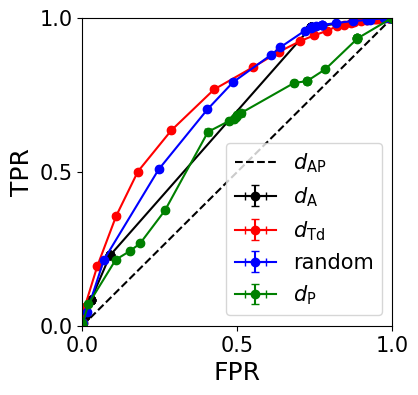

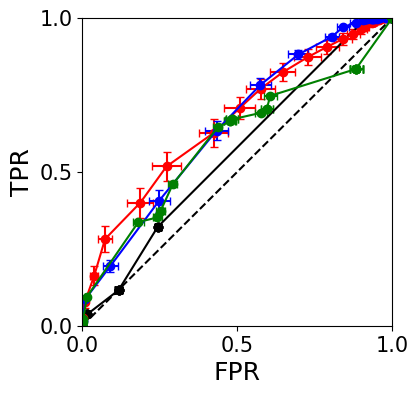

In [31]:
dvec = [1]; # if higher distanced needed -- generate pairs then append dvec
Rep = 15
zM_out = [[],[],[],[],[]]
zM_out_err = [[],[],[],[],[]]
zV_out = [[],[],[],[],[]]
zV_out_err = [[],[],[],[],[]]
for k in range(len(dvec)):
    print('step ' + str(k+1) + ' / ' + str(len(dvec)) + '...')
    d = dvec[k]
    ########
    x0_M, y0_M, x0t_M, y0t_M, z_M, z_t_M = MIRA_check(MMR, d, Rep, AW_d, PW_d)
    x0_V, y0_V, x0t_V, y0t_V, z_V, z_t_V = VDJ_check(MMR, d, Rep, AW_d, PW_d)
    ########
    x0_M_AA, y0_M_AA, _, _, z_M_AA, _ = MIRA_check(MMR, d, Rep, AW, 10000*np.ones([30,30]))
    x0_V_AA, y0_V_AA, _, _, z_V_AA, _ = VDJ_check(MMR, d, Rep, AW, 10000*np.ones([30,30]))
    ########
    x0_M_pos, y0_M_pos, _, _, z_M_pos, _ = MIRA_check(MMR, d, Rep, 10000*np.ones([21,21]), PW)
    x0_V_pos, y0_V_pos, _, _, z_V_pos, _ = VDJ_check(MMR, d, Rep, 10000*np.ones([21,21]),PW)
    ########
    ########
    zM_out[0].append(np.mean(z_t_M)); zM_out_err[0].append(np.std(z_t_M)/np.sqrt(Rep-1))
    zM_out[3].append(np.mean(z_M)); zM_out_err[3].append(np.std(z_M)/np.sqrt(Rep-1))
    zM_out[2].append(np.mean(z_M_AA)); zM_out_err[2].append(np.std(z_M_AA)/np.sqrt(Rep-1))
    zM_out[1].append(np.mean(z_M_pos)); zM_out_err[1].append(np.std(z_M_pos)/np.sqrt(Rep-1))
    ########
    zV_out[0].append(np.mean(z_t_V)); zV_out_err[0].append(np.std(z_t_V)/np.sqrt(Rep-1))
    zV_out[3].append(np.mean(z_V)); zV_out_err[3].append(np.std(z_V)/np.sqrt(Rep-1))
    zV_out[2].append(np.mean(z_V_AA)); zV_out_err[2].append(np.std(z_V_AA)/np.sqrt(Rep-1))
    zV_out[1].append(np.mean(z_V_pos)); zV_out_err[1].append(np.std(z_V_pos)/np.sqrt(Rep-1))
    ########
    if d == 1:
        plt.figure(figsize=(4,4))
        plt.plot([0,1],[0,1],'k--')
        plt.errorbar(np.mean(x0t_M,0), np.mean(y0t_M,0),xerr=np.std(x0t_M,0)/np.sqrt(Rep-1), yerr=np.std(y0t_M,0)/np.sqrt(Rep-1), capsize=3, fmt="ko-") 
        plt.errorbar(np.mean(x0_M,0), np.mean(y0_M,0), xerr=np.std(x0_M,0)/np.sqrt(Rep-1) ,yerr=np.std(y0_M,0)/np.sqrt(Rep-1), capsize=3, fmt="ro-")        
        plt.errorbar(np.mean(x0_M_AA,0), np.mean(y0_M_AA,0), xerr=np.std(x0_M_AA,0)/np.sqrt(Rep-1) ,yerr=np.std(y0_M_AA,0)/np.sqrt(Rep-1), capsize=3, fmt="bo-")        
        plt.errorbar(np.mean(x0_M_pos,0), np.mean(y0_M_pos,0), xerr=np.std(x0_M_pos,0)/np.sqrt(Rep-1) ,yerr=np.std(y0_M_pos,0)/np.sqrt(Rep-1), capsize=3, fmt="go-")        

        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.xticks([0,0.5,1]);
        plt.yticks([0,0.5,1]);
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.legend({'random','$d_\mathrm{Td}$','$d_\mathrm{AP}$','$d_\mathrm{A}$','$d_\mathrm{P}$'})

        ########
        plt.figure(figsize=(4,4))
        plt.plot([0,1],[0,1],'k--')
        plt.errorbar(np.mean(x0t_V,0), np.mean(y0t_V,0),xerr=np.std(x0t_V,0)/np.sqrt(Rep-1), yerr=np.std(y0t_V,0)/np.sqrt(Rep-1), capsize=3, fmt="ko-") 
        plt.errorbar(np.mean(x0_V,0), np.mean(y0_V,0), xerr=np.std(x0_V,0)/np.sqrt(Rep-1) ,yerr=np.std(y0_V,0)/np.sqrt(Rep-1), capsize=3, fmt="ro-")        
        plt.errorbar(np.mean(x0_V_AA,0), np.mean(y0_V_AA,0), xerr=np.std(x0_V_AA,0)/np.sqrt(Rep-1) ,yerr=np.std(y0_V_AA,0)/np.sqrt(Rep-1), capsize=3, fmt="bo-")        
        plt.errorbar(np.mean(x0_V_pos,0), np.mean(y0_V_pos,0), xerr=np.std(x0_V_pos,0)/np.sqrt(Rep-1) ,yerr=np.std(y0_V_pos,0)/np.sqrt(Rep-1), capsize=3, fmt="go-")        
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.xticks([0,0.5,1]);
        plt.yticks([0,0.5,1]);
        plt.xlabel('FPR')
        plt.ylabel('TPR')

<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
/var/folders/zm/c02xmwfx58l3xfx_hgwyrdgw0000gn/T/ipykernel_74894/263700223.py:14: SyntaxWarning: invalid escape sequence '\m'
  dmet = ['$d_\mathrm{Td}$','$d_\mathrm{A}$','$d_\mathrm{P}$','$d_\mathrm{AP}$']
/var/folders/zm/c02xmwfx58l3xfx_hgwyrdgw0000gn/T/ipykernel_74894/263700223.py:14: SyntaxWarning: invalid escape sequence '\m'
  dmet = ['$d_\mathrm{Td}$','$d_\mathrm{A}$','$d_\mathrm{P}$','$d_\mathrm{AP}$']
/var/folders/zm/c02xmwfx58l3xfx_hgwyrdgw0000gn/T/ipykernel_74894/263700223.py:14: SyntaxWarning: invalid escape sequence '\m'
  dmet = ['$d_\mathrm{Td}$','$d_\mathrm{A}$','$d_\ma

([<matplotlib.axis.YTick at 0x166b59450>,
 [Text(0, 0.5, '0.5'),
  Text(0, 0.6, '0.6'),
  Text(0, 0.7, '0.7'),
  Text(0, 0.8, '0.8')])

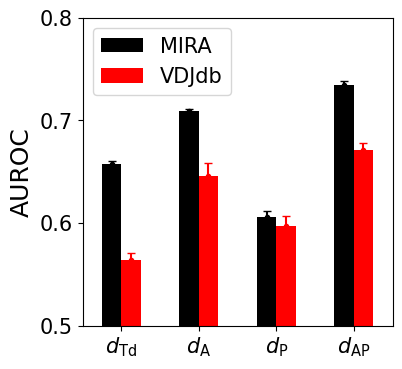

In [43]:
k = 0

z_MIRA = [x[k] for x in zM_out[0:4]]
z_VDJ = [x[k] for x in zV_out[0:4]]
z_MIRA_err = [x[k] for x in zM_out_err[0:4]]
z_VDJ_err = [x[k] for x in zV_out_err[0:4]]
             
temp1 = z_MIRA[1]; temp2 = z_MIRA[2]; z_MIRA[1] = temp2; z_MIRA[2] = temp1
temp1 = z_MIRA_err[1]; temp2 = z_MIRA_err[2]; z_MIRA_err[1] = temp2; z_MIRA_err[2] = temp1
temp1 = z_VDJ[1]; temp2 = z_VDJ[2]; z_VDJ[1] = temp2; z_VDJ[2] = temp1
temp1 = z_VDJ_err[1]; temp2 = z_VDJ_err[2]; z_VDJ_err[1] = temp2; z_VDJ_err[2] = temp1
             

dmet = ['$d_\mathrm{Td}$','$d_\mathrm{A}$','$d_\mathrm{P}$','$d_\mathrm{AP}$']

plt.figure(figsize = (4,4))
x = np.array([1,2,3,4])
plt.bar(x-0.125,z_MIRA,color='k',width=0.25)
plt.bar(x+0.125,z_VDJ,color='r',width=0.25)
plt.ylim([0.5,0.8])
plt.xlim([0.5,4.5])
plt.xticks([1,2,3,4], dmet)


plt.errorbar(x-0.125,z_MIRA,z_MIRA_err,capsize=3, fmt="k.")
plt.errorbar(x+0.125,z_VDJ,z_VDJ_err,capsize=3, fmt="r.")

plt.legend(['MIRA','VDJdb'])
plt.ylabel('AUROC')
plt.yticks([0.5,0.6,0.7,0.8])